In [1]:
m = {
            'name' : 'Mario', 
            'game' : 'super mario sunshine', 
            'height' : 4.6,
            'nationality' : 'italian'
          }

l = {
            'name' : 'Luigi', 
            'game' : 'super mario bros 2', 
            'height' : 5.1,
            'nationality' : 'italian'
          }

w = {
            'name' : 'wario', 
            'game' : 'warioware', 
            'height' : 4.6,
            'nationality' : 'italian'
          }

valm = set(m.values())
vall = set(l.values())
valw = set(w.values())

common = set.intersection(valm, vall, valw)
print(common)

{'italian'}


In [4]:
{key: value for key,value in m.items() if m[key] == 'italian'}

{'nationality': 'italian'}

In [10]:
a = [1,2,3]
b = ['a', 'b', 'c']

d = dict(zip(a, b))
d

{1: 'a', 2: 'b', 3: 'c'}

In [9]:
L = [[3,2,1],[1,7,6],[2,7,7]]
print(list(zip(*L)))

[(3, 1, 2), (2, 7, 7), (1, 6, 7)]


# Prelim

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from PIL import Image
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference', torch.cuda.get_device_name())

Using cuda for inference NVIDIA GeForce RTX 3080


In [4]:
train_path = Path('C:/Users/19368/Desktop/KaggleDigitRecognizer/datasets/train')
test_path = Path('C:/Users/19368/Desktop/KaggleDigitRecognizer/datasets/test')
linear_relu_stack_results_path = Path('C:/Users/19368/Desktop/KaggleDigitRecognizer/results/linear_relu_stack')

In [5]:
train_df = pd.read_csv(train_path / 'train.csv')
test_df = pd.read_csv(test_path /  'test.csv')
# Test data has no labels. It's for creating submission.

In [6]:
train_data = train_df.to_numpy(dtype=np.float32)
test_data = test_df.to_numpy(dtype=np.float32)

In [7]:
train_dataset = []
batch_size = 100

for i in range(len(train_data)):
   train_dataset.append([train_data[i][0], train_data[i][1:]])

test_dataset = test_data

# Dataloader needs [label, [data]]
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

Feature batch shape: torch.Size([100, 784])
Labels batch shape: torch.Size([100])


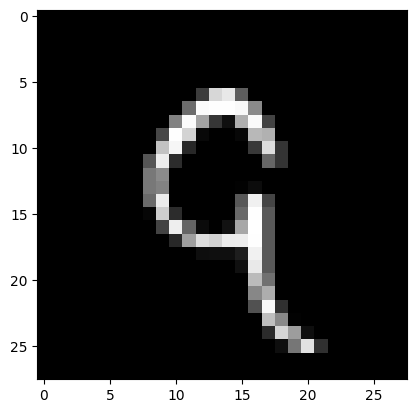

Label: 9.0


In [8]:
# Display image and label.
train_labels, train_features  = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].reshape(-1, 28, 28).squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Basic Linear / ReLu Stack - 95% Accuracy

In [9]:
# Linear and ReLU stack - with CrossEntropyLoss function, this is the same as using a LogSoftmax activation with a NLLLoss function.

from torch import nn

loss_fn = nn.CrossEntropyLoss()

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512).float(),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)

#95% accuracy - tweaking learning rate and adding more layers did not really affect accuracy.

#model hyper-parameters
learning_rate = 1e-3
epochs = 25

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (y, X) in enumerate(dataloader): 
        pred = model(X.to(torch.float32).to(device)) # lin-relu stack
        loss = loss_fn(pred, y.type(torch.LongTensor).to(device))
 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [15]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 4.711944  [  100/42000]
loss: 0.551658  [10100/42000]
loss: 0.342623  [20100/42000]
loss: 0.331821  [30100/42000]
loss: 0.261595  [40100/42000]
Epoch 2
-------------------------------
loss: 0.250537  [  100/42000]
loss: 0.152658  [10100/42000]
loss: 0.348933  [20100/42000]
loss: 0.103080  [30100/42000]
loss: 0.120530  [40100/42000]
Epoch 3
-------------------------------
loss: 0.086815  [  100/42000]
loss: 0.181874  [10100/42000]
loss: 0.145029  [20100/42000]
loss: 0.117780  [30100/42000]
loss: 0.118043  [40100/42000]
Epoch 4
-------------------------------
loss: 0.090778  [  100/42000]
loss: 0.130483  [10100/42000]
loss: 0.109469  [20100/42000]
loss: 0.032442  [30100/42000]
loss: 0.096490  [40100/42000]
Epoch 5
-------------------------------
loss: 0.128190  [  100/42000]
loss: 0.122919  [10100/42000]
loss: 0.051967  [20100/42000]
loss: 0.076618  [30100/42000]
loss: 0.115576  [40100/42000]
Epoch 6
-------------------------------
loss: 0.06

In [ ]:
model.eval()
pred_list = []
for i in range(len(test_data)):
    with torch.no_grad():
      pred_list.append( model(torch.from_numpy( test_data[i] ) ).data.numpy().argmax() )

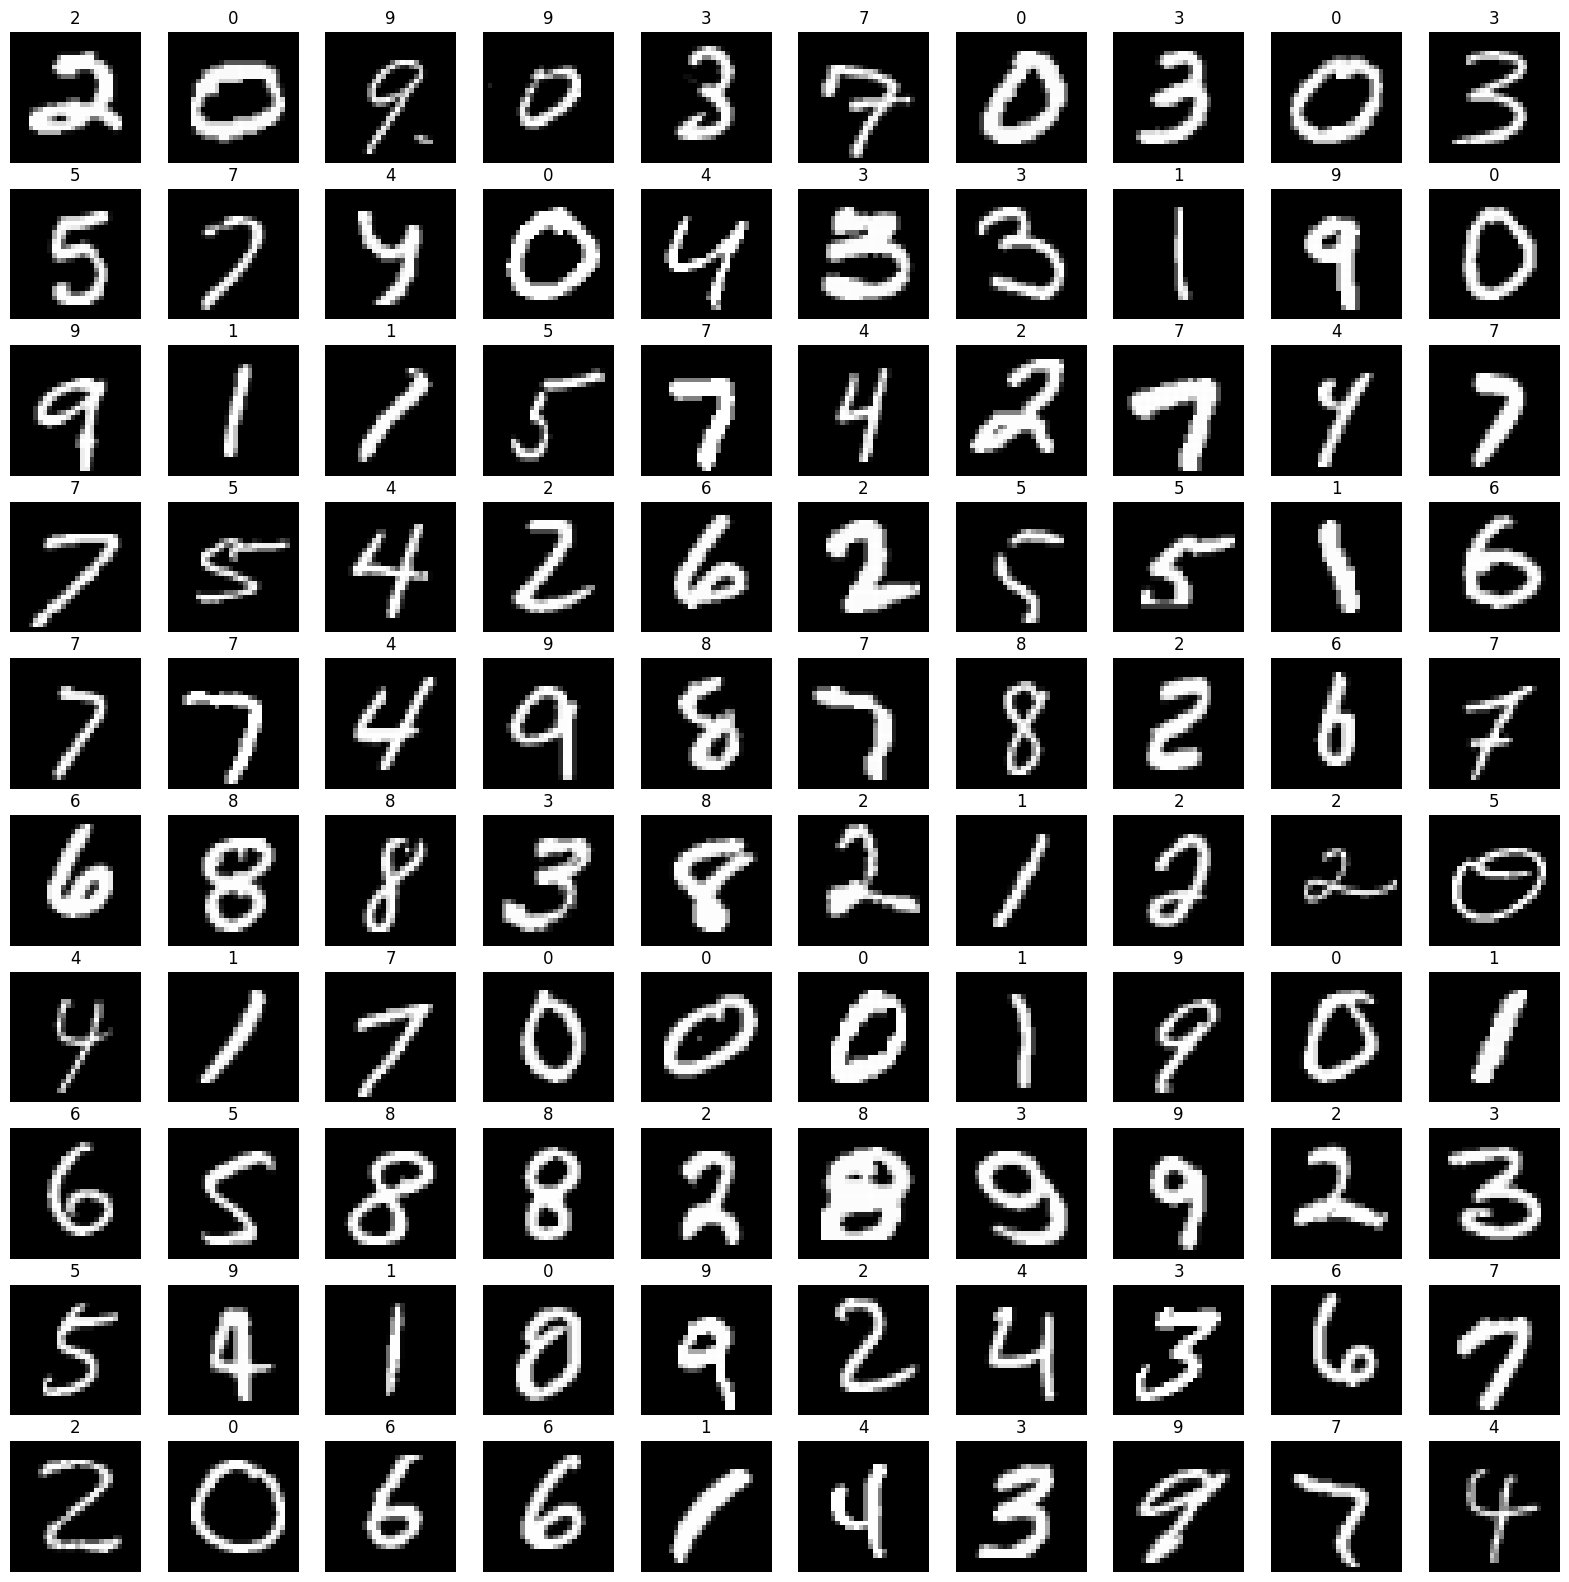

In [18]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20,20))

i=0
for row in axes:
    for col in row:
        img = test_data[i].reshape(-1, 28, 28).squeeze()
        col.imshow(img, cmap="gray")
        col.title.set_text(pred_list[i])
        i+=1
        col.axis('off')

plt.show()

In [ ]:
results_df = pd.read_csv('results/sample_submission.csv')
results_df['Label'] = pred_list

In [23]:
m = len(os.listdir(linear_relu_stack_results_path))
results_df.to_csv('results/linear_relu_stack/linear_relu_stack_%d.csv' % m, index=False)

# CNN

In [ ]:
# # Convolutional 2D network

#loss function
loss_fn = nn.CrossEntropyLoss()

# hyper-parameters
learning_rate = 1e-3
epochs = 25

class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(2304, 10)
        )

    def forward(self, x):
        out = self.main(x)
        return out

model = CNN().to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (y, X) in enumerate(dataloader): 
        pred = model(X.reshape(50, 1, 28, 28).to(torch.float32)) # conv stack
        loss = loss_fn(pred, y.type(torch.LongTensor))
 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")